# Data Science with Python - Course 1 - Week 7 - Machine Learning

## Lectures

### Introduction to *Blue Book for Bulldozers*

Blue Book for Bulldozers Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very common type of dataset and prediciton problem, and similar to what you may see in your project or workplace.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn.tree import DecisionTreeRegressor

from sklearn import metrics
import pandas as pd
import numpy as np
from structured import *

In [3]:
PATH = "data/"

In [4]:
!ls {PATH}

Test.csv          Train.csv         TrainAndValid.csv Valid.csv


### The data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

*Question*

What stands out to you from the above description?  What needs to be true of our training and validation sets?

`pandas` is the most important library when you are working with structured data which is usually imported as `pd`.

In [5]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

* `parse_dates`  —  A list of any columns that contain dates
* `low_memory=False`  —  Forces it to read more of the file to decide what the types are.

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [6]:
df_raw.shape

(401125, 53)

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 5, "display.max_columns", 10): 
        display(df)

In [8]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
...,...,...,...,...,...
Differential_Type,NaN,NaN,NaN,NaN,NaN
Steering_Controls,NaN,NaN,NaN,NaN,NaN


In [9]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,...,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,...,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,...,4750,14500,24000,40000,142000
...,...,...,...,...,...,...,...,...,...,...,...
Differential_Type,69411,4,Standard,68073,NaN,...,NaN,NaN,NaN,NaN,NaN
Steering_Controls,69369,5,Conventional,68679,NaN,...,NaN,NaN,NaN,NaN,NaN


The variable we want to predict is called *Dependent Variable* in this case our dependent variable is `SalePrice`.

It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [8]:
    df_raw.SalePrice = np.log(df_raw.SalePrice)

### Machine Learning - Decision Tree

Everything in *scikit-learn* has the same form.

* Create an instance of an object for the machine learning model
* Call `fit` by passing in the independent variables (the things you are going to use to predict) and dependent variable (the thing you want to predict).
* `axis=1` means remove columns.
* shift + tab in Jupyter Notebook will bring up the inspection of the parameters of a function.
* `“list-like”` means anything you can index in Python.

* DecisionTreeClassifier is a class capable of performing multi-class classification on a dataset.
* Decision trees can also be applied to regression problems, using the DecisionTreeRegressor class.
* http://scikit-learn.org/stable/modules/tree.html#tree

In [9]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Conventional'

### Data Pre-processing

The above code will result in an error. There was a value inside the dataset “Conventional”, and it did not know how to create a model using that String. We have to pass numbers to most machine learning models and certainly to random forests. So step 1 is to convert everything into numbers.

This dataset contains a mix of **continuous** and **categorical** variables.

**continuous** — numbers where the meaning is numeric such as price.
categorical — either numbers where the meaning is not continuous like zip code or string such as “large”, “medium”, “small”
Here are some of the information we can extract from date — year, month, quarter, day of month, day of week, week of year, is it a holiday? weekend? was it raining? was there a sport event that day? It really depends on what you are doing. If you are predicting soda sales in SoMa, you would probably want to know if there was a San Francisco Giants ball game that day. What is in a date is one of the most important piece of feature engineering you can do and no machine learning algorithm can tell you whether the Giants were playing that day and that it was important. So this is where you need to do feature engineering.

The `add_datepart` method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can’t capture any trend/cyclical behavior as a function of time at any of these granularities.

In [12]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [13]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,...,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,1.91971e+06,...,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,10.1031,...,8.4659,9.5819,10.0858,10.5966,11.8636
...,...,...,...,...,...,...,...,...,...,...,...
saleIs_year_start,401125,1,False,401125,NaN,...,NaN,NaN,NaN,NaN,NaN
saleElapsed,401125,NaN,NaN,NaN,1.09143e+09,...,6.00998e+08,9.70877e+08,1.14307e+09,1.23785e+09,1.3252e+09


After running `add_datepart`, it added many numerical columns and removed `saledate` column. This is not quite enough to get passed the error we saw earlier as we still have other columns that contain string values. Pandas has a concept of a category data type, but by default it would not turn anything into a category for you. `train_cats` creates categorical variables for everything that is a String. Behind the scenes, it creates a column that is an integer and it is going to store a mapping from the integers to the strings. `train_cats` is called “train” because it is training data specific. It is important that validation and test sets will use the same category mappings (in other words, if you used 1 for “high” for a training dataset, then 1 should also be for “high” in validation and test datasets). For validation and test dataset, use apply_cats instead.



The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [14]:
train_cats(df_raw)

In [15]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

The order does not matter too much, but since we are going to be creating a decision tree that split things at a single point (i.e. `High` vs. `Low` and `Medium` , `High` and `Low` vs. `Medium` ) which is a little bit weird. To order them in a sensible manner, you can do the following:

In [16]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

`inplace` will ask Pandas to change the existing dataframe rather than returning a new one.

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [17]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [18]:
print(df_raw.UsageBand)

0         2
1         2
2         0
3         0
4         1
5         2
6         0
7         0
8         2
9         1
10        1
11        2
12       -1
13        1
14        2
15        1
16        2
17       -1
18        2
19        1
20        1
21        1
22        2
23        0
24        1
25        1
26        2
27       -1
28        2
29        1
         ..
401095   -1
401096   -1
401097   -1
401098   -1
401099   -1
401100   -1
401101   -1
401102   -1
401103   -1
401104   -1
401105   -1
401106   -1
401107   -1
401108   -1
401109   -1
401110   -1
401111   -1
401112   -1
401113   -1
401114   -1
401115   -1
401116   -1
401117   -1
401118   -1
401119   -1
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Name: UsageBand, Length: 401125, dtype: int8


We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a decision tree.

In [19]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting    0.803872
Blade_Extension     0.937129
                      ...   
saleYear            0.000000
state               0.000000
Length: 65, dtype: float64

### Continue to pre-process data

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [20]:
df, y, nas = proc_df(df_raw, 'SalePrice')

* `df` — data frame
* `y_fld` — name of the dependent variable
* It makes a copy of the data frame, grab the dependent variable values `(y_fld)`, and drop the dependent variable from the data frame.
* Then it will `fix_missing` (see below)
* We then will go through the data frame and call `numericalize` (see below).
* `dummies` — There are columns with a small number of possible values, you can put into dummies instead of numericalizing them. But we will not do that for now.

`fix_missing`
* For numeric data type, first we check if there is null column. If so, it will create a new column with a name with `_na` appended at the end and set it to 1 if it is missing; 0 otherwise (boolean). It will then replace the missing value with a median.
* We do not need to do this for categorical variables because Pandas handles them automatically by setting them to `-1`.


`numericalize`
If it is not numeric and is a categorical type, we will replace the column with its code plus 1. By default pandas uses -1 for missing, so now missing will have an ID of 0 .

In [21]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,2,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,2,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,0,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,0,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,1,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


Now we have all numerical values. Note that booleans are treated as numbers. So we can create a decision tree.

In [22]:
# Note: change max_depth
tree = DecisionTreeRegressor(max_depth=15)
tree.fit(df, y)
tree.score(df,y)

0.89651380406574799

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

In [23]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 120000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((281125, 66), (281125,), (120000, 66), (120000,))

## Base model

Let's try our model again, this time with separate training and validation sets.

In [24]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [25]:
tree = DecisionTreeRegressor(max_depth=3)
%time tree.fit(X_train, y_train)
print_score(tree)

CPU times: user 1.77 s, sys: 163 ms, total: 1.93 s
Wall time: 1.95 s
[0.5218219098000535, 0.5778088470147987, 0.42218920585761377, 0.3343648326464212]


### Speed things up

In [26]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, 
                     na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [27]:
tree = DecisionTreeRegressor(max_depth=3)
%time tree.fit(X_train, y_train)
print_score(tree)

CPU times: user 113 ms, sys: 23.1 ms, total: 136 ms
Wall time: 136 ms
[0.5231475506475121, 0.5807822355780823, 0.40746439883522667, 0.32749652511467298]


### Visualize 

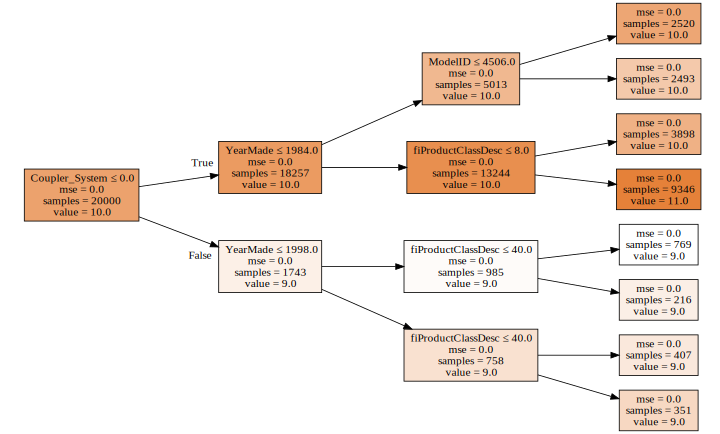

In [28]:
draw_tree(tree, df_trn)

A tree consists of a sequence of binary decisions.

* The first line indicates the binary split criteria
samples at the root is 20,000 since that is what we specified when splitting the data.
* Darker color indicates higher `value`
* `value` is average of the log of price, and if we built a model where we just used the average all the time, then the mean squared error mse would be 0.495
* The best single binary split we can make turns out to be Coupler_system ≤ 0.5 which will improve mse to 0.109 in false path; 0.414 in true path.

Create a tree. How are you going to do it?

* We need to pick a variable and the value to split on such that the two groups are as different to each other as possible
* For each variable, for each possible value of the possible value of that variable see whether it is better.
* How to determine if it is better? Take weighted average of two new nodes
* The resulting model will be similar to the naïve model of means — we have a model with a single binary decision. For everybody with `coupler_system` greater than 0.5, we will fill in 10.345, for everybody else, we will put 9.363. Then we will calculate RMSE of this model.


### Another way to split data

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df,
    y,
    test_size=0.25,
    random_state=42,
)

In [32]:
tree = DecisionTreeRegressor(max_depth=5)
%time tree.fit(X_train, y_train)
tree.score(X_train, y_train)

CPU times: user 3.12 s, sys: 214 ms, total: 3.33 s
Wall time: 3.5 s


0.57610474712874837

In [33]:
tree.score(X_test, y_test)

0.57340398308078488

## Linear Regression

In [34]:
df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [40]:
df, y, nas, mapper = proc_df(df_raw, 'SalePrice', max_n_cat=10, do_scale=True)

In [41]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df)-n_valid
y_train, y_valid = split_vals(y, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [42]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

### Check data after scaling

In [43]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SalesID,401125.0,1.451110e-16,1.000001,-0.858580,-0.551518,-0.308344,0.355322,4.855369
MachineID,401125.0,-2.879547e-16,1.000001,-2.761738,-0.292989,0.139657,0.567277,2.876309
ModelID,401125.0,-5.895135e-17,1.000001,-1.102854,-0.583548,-0.367372,0.294819,4.871330
datasource,401125.0,7.164857e-16,1.000001,-1.524823,-0.297450,-0.297450,0.148868,4.165727
auctioneerID,401125.0,-4.959850e-18,1.000001,-0.381738,-0.321407,-0.261075,-0.140412,5.591096
YearMade,401125.0,2.536609e-16,1.000001,-3.081446,0.294188,0.328458,0.345593,0.390145
MachineHoursCurrentMeter,401125.0,-6.235239e-18,1.000001,-0.074396,-0.074396,-0.074396,-0.074396,150.038499
UsageBand,401125.0,3.627776e-17,1.000001,-0.432158,-0.432158,-0.432158,-0.432158,3.014971
fiModelDesc,401125.0,1.673709e+03,1263.331163,1.000000,631.000000,1395.000000,2292.000000,4999.000000
fiBaseModel,401125.0,5.591654e+02,469.310266,1.000000,206.000000,406.000000,704.000000,1950.000000


In [44]:
X_train, X_valid = split_vals(df, n_trn)

In [46]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

m = LinearRegression().fit(X_train, y_train)
m.score(X_valid, y_valid)

0.24544985191269261

In [47]:
m.score(X_train, y_train)

0.60859797089105228

In [49]:
preds = m.predict(X_valid)

In [50]:
rmse(preds, y_valid)

0.6500100438523817

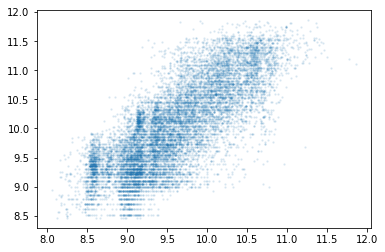

In [51]:
# Scatter plot
plt.scatter(preds, y_valid, alpha=0.1, s=2);

### Reference
1. fastai.com (http://course.fast.ai/ml.html)
2. https://medium.com/@hiromi_suenaga/machine-learning-1-lesson-1-84a1dc2b5236
3. https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/


## Homework #7

1. Save the trained model to a file.
2. Load the trained model back and do prediction for validation and testing dataset.
3. (Optional) Use `Random Forest` (instead of `Decision Tree`) for the above problem. 
4. With `Linear Regression` method, please use `Feature Selection` based on correlation scores.